In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


In [20]:
df = pd.read_csv(r'C:\Users\saura\OneDrive\Desktop\Data_Viz_Playground\Time Series Forecasting\Hourly Energy Consumption\PJME_hourly.csv', encoding = 'unicode_escape')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)


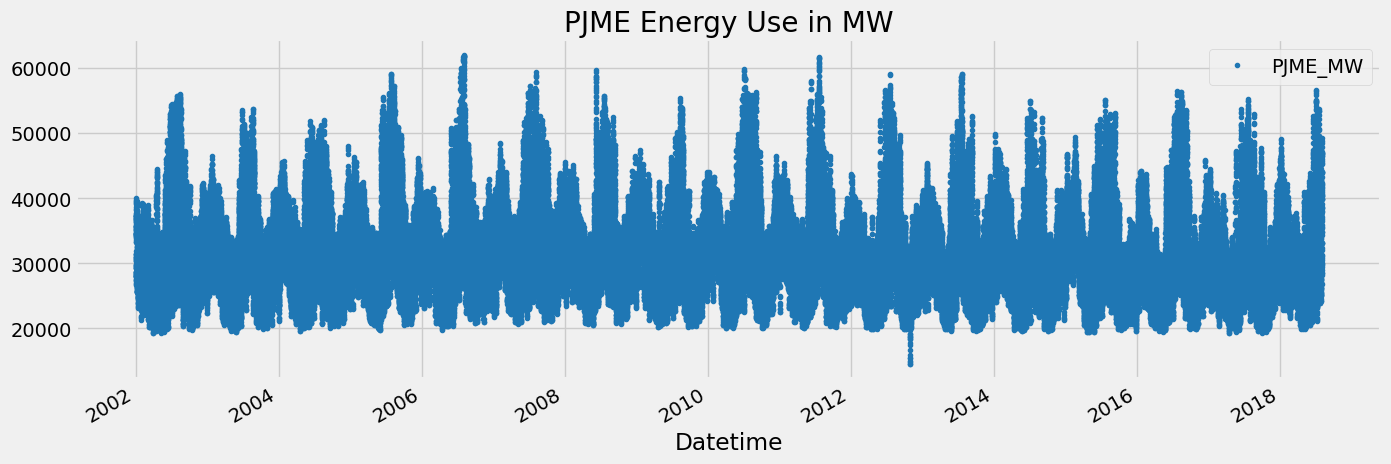

In [21]:
df.plot(style = '.',
        figsize = (15, 5),
        color = color_pal[0],
        title = 'PJME Energy Use in MW'
)
plt.show()

### Train/Test Split

In [ ]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize = (15, 5))
train.plot(ax = ax, label = 'Training Set', title = 'Data Train/Test Split')
test.plot(ax = ax, label = 'Test Set')
ax.axvline('01-01-2015', color = 'black', ls = '--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

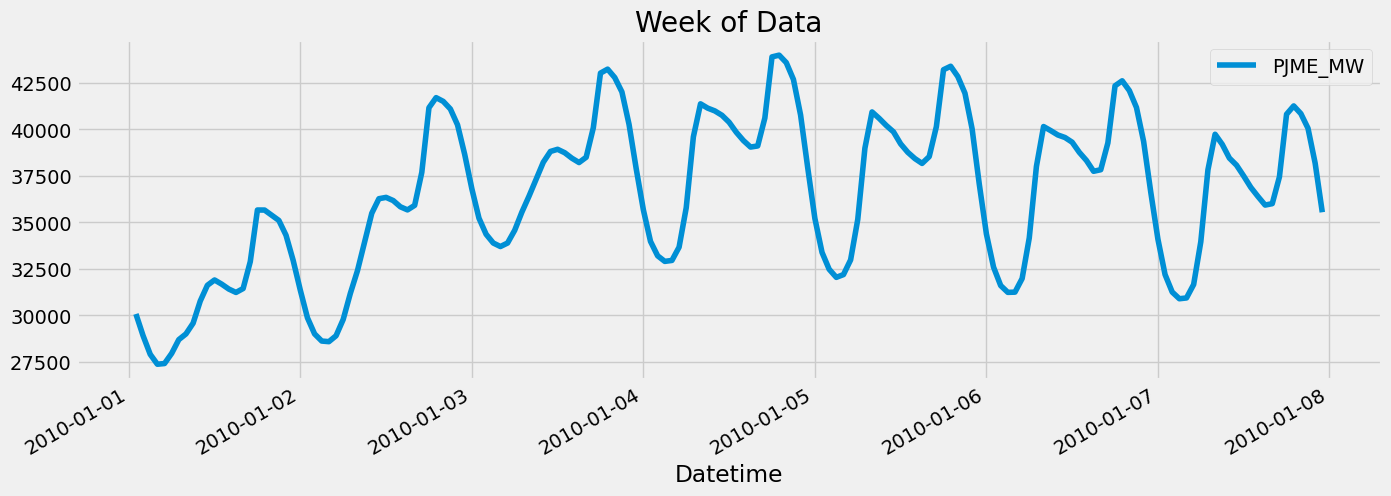

In [26]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize = (15, 5), title = 'Week of Data')
plt.show()

### Feature Creation

In [72]:
def create_features(df):
    """
        Create times series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

### Visualise our Feature/Target Relationship

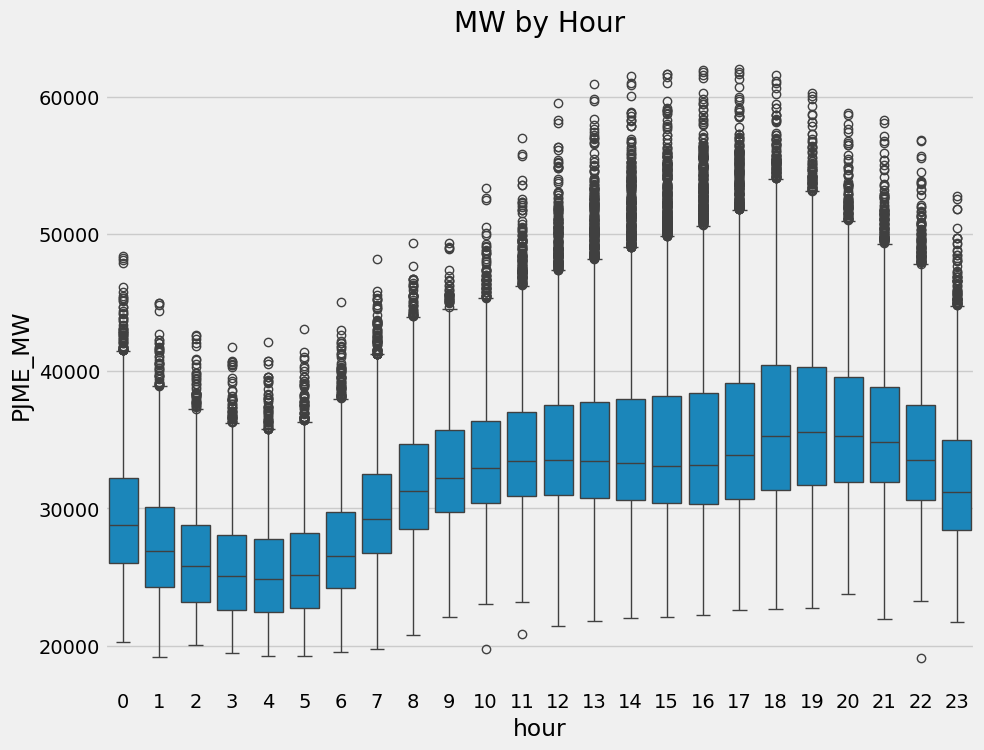

In [73]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.boxplot(data = df, x = 'hour', y = 'PJME_MW')
ax.set_title('MW by Hour')
plt.show()

C:\Users\saura\AppData\Local\Temp\ipykernel_20984\2765918347.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df, x = 'month', y = 'PJME_MW', palette = 'Blues')


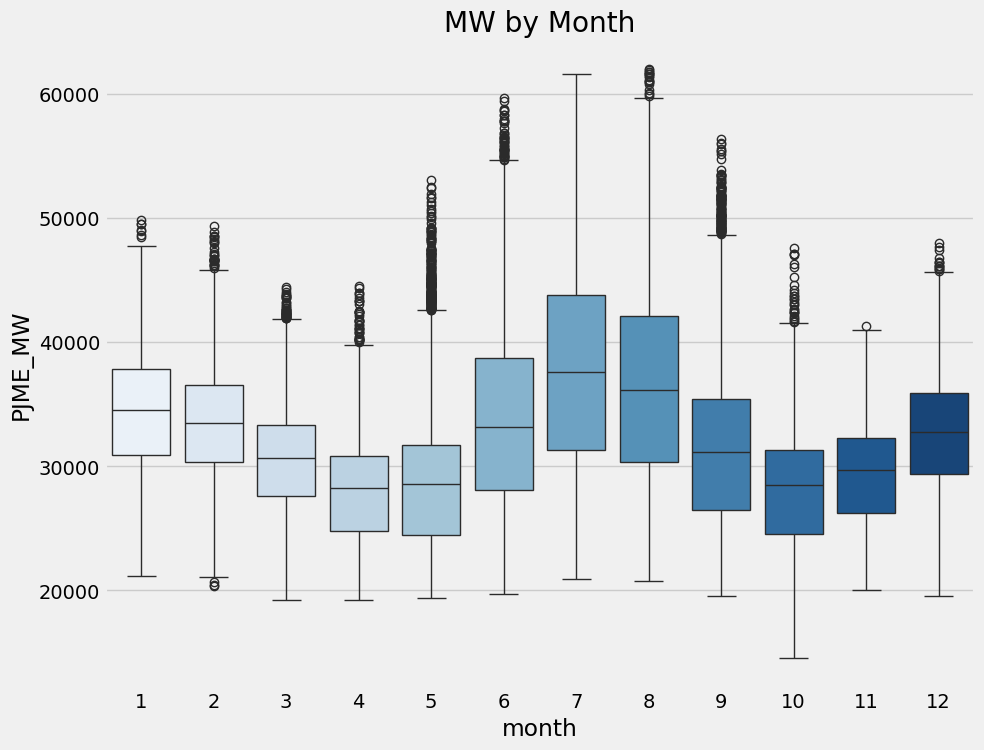

In [33]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.boxplot(data = df, x = 'month', y = 'PJME_MW', palette = 'Blues')
ax.set_title('MW by Month')
plt.show()

### Create our Model

In [34]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(base_score = 0.5, booster = 'gbtree',
        n_estimators = 1000,
        early_stopping_rounds = 50,
        objective = 'reg:linear',
        max_depth = 3,
        learning_rate = 0.01)

reg.fit(X_train, y_train, 
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose = 100)

### Feature Importance

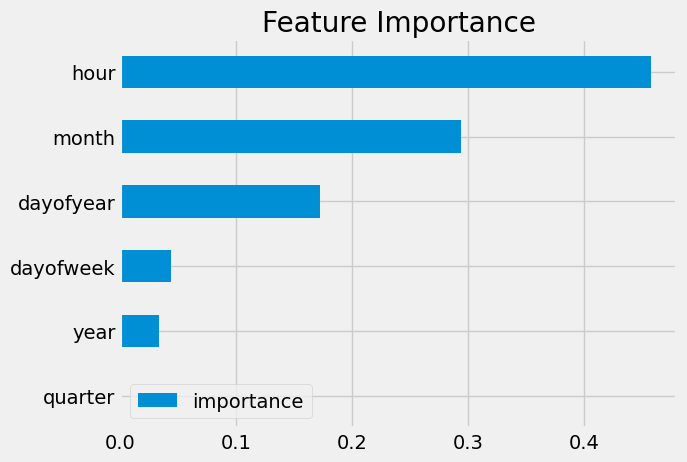

In [49]:
fi = pd.DataFrame(data = reg.feature_importances_,
                  index = reg.feature_names_in_,
                  columns = ['importance'])
fi.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance')
plt.show()

### Forecast on Test

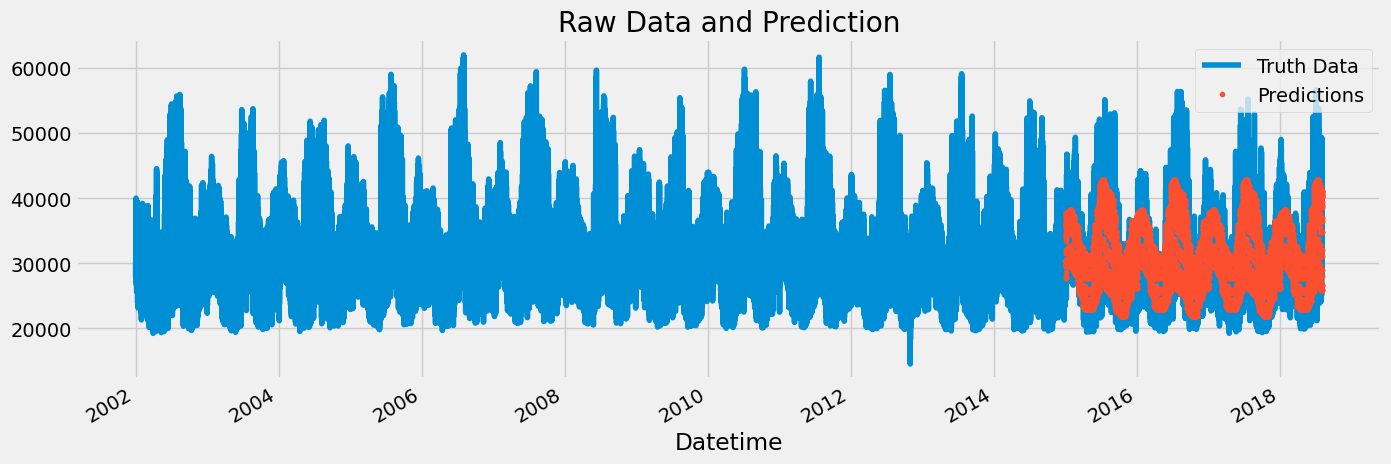

In [50]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how = 'left', left_index = True, right_index = True)
ax = df[['PJME_MW']].plot(figsize = (15,5))
df['prediction'].plot(ax = ax, style = '.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

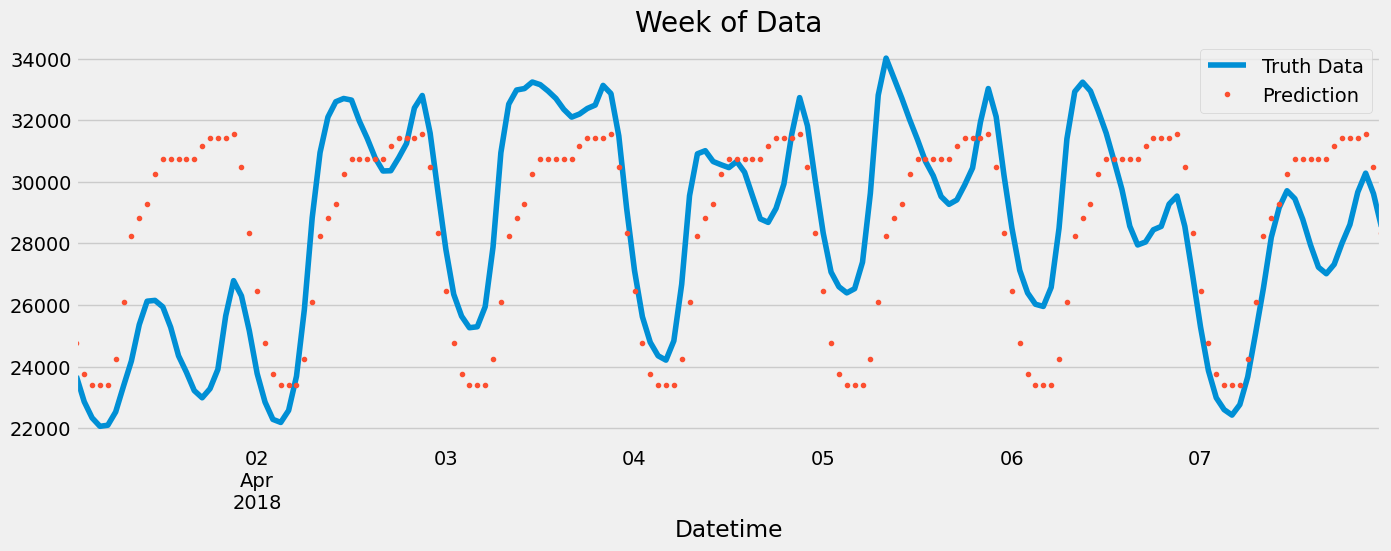

In [55]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize = (15, 5), title = 'Week of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'].plot(style = '.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()


### Score (RMSE)

In [60]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score: 0.2f}')

RMSE Score on Test set:  3998.18


### Calculate Error

*Look at the worst and best predicted days*

In [62]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending = False).head(10)

date
2016-09-09    11798.300944
2015-02-20    11592.439372
2016-08-12    10910.316243
2016-08-13    10639.667318
2015-02-16    10548.584473
2016-08-11    10411.066243
2015-09-09    10090.056559
2017-05-19    10048.498942
2016-08-14     9881.167318
2016-07-03     9593.964437
Name: error, dtype: float64

### 1. Outlier Analysis and removal

In [ ]:
df['PJME_MW'].plot(kind = 'hist', bins = 500)

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

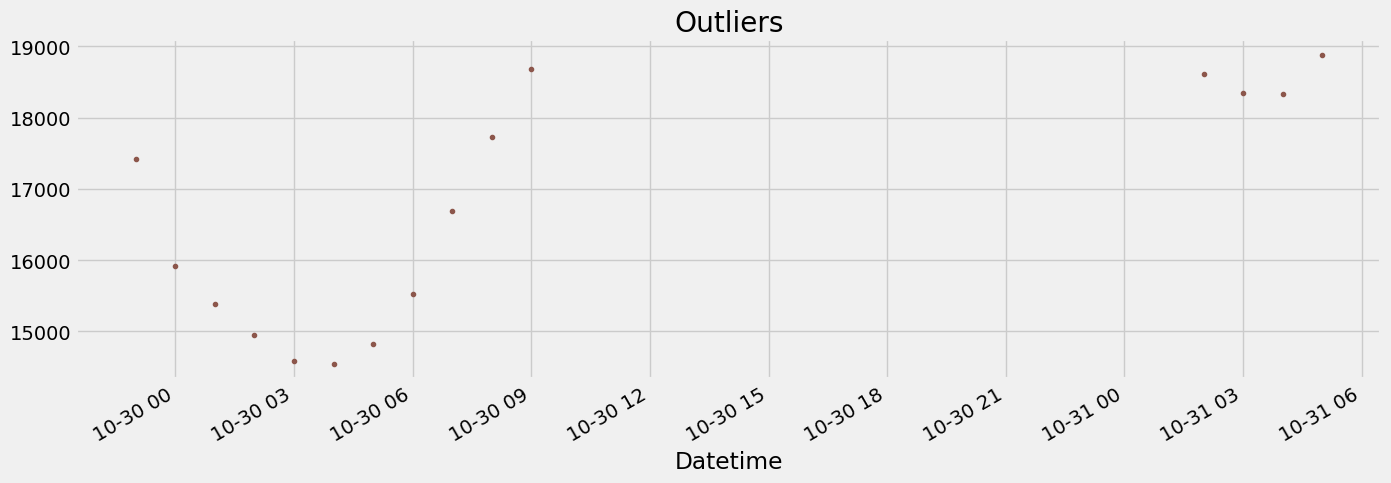

In [65]:
df.query('PJME_MW < 19_000')['PJME_MW'].plot(
    style = '.',
    figsize = (15, 5),
    color = color_pal[5],
    title = 'Outliers'
)

In [66]:
df = df.query('PJME_MW > 19_000').copy()

### 1. Time Series Cross Validation

In [70]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 5, test_size = 24*365*1, gap = 24)
df = df.sort_index()

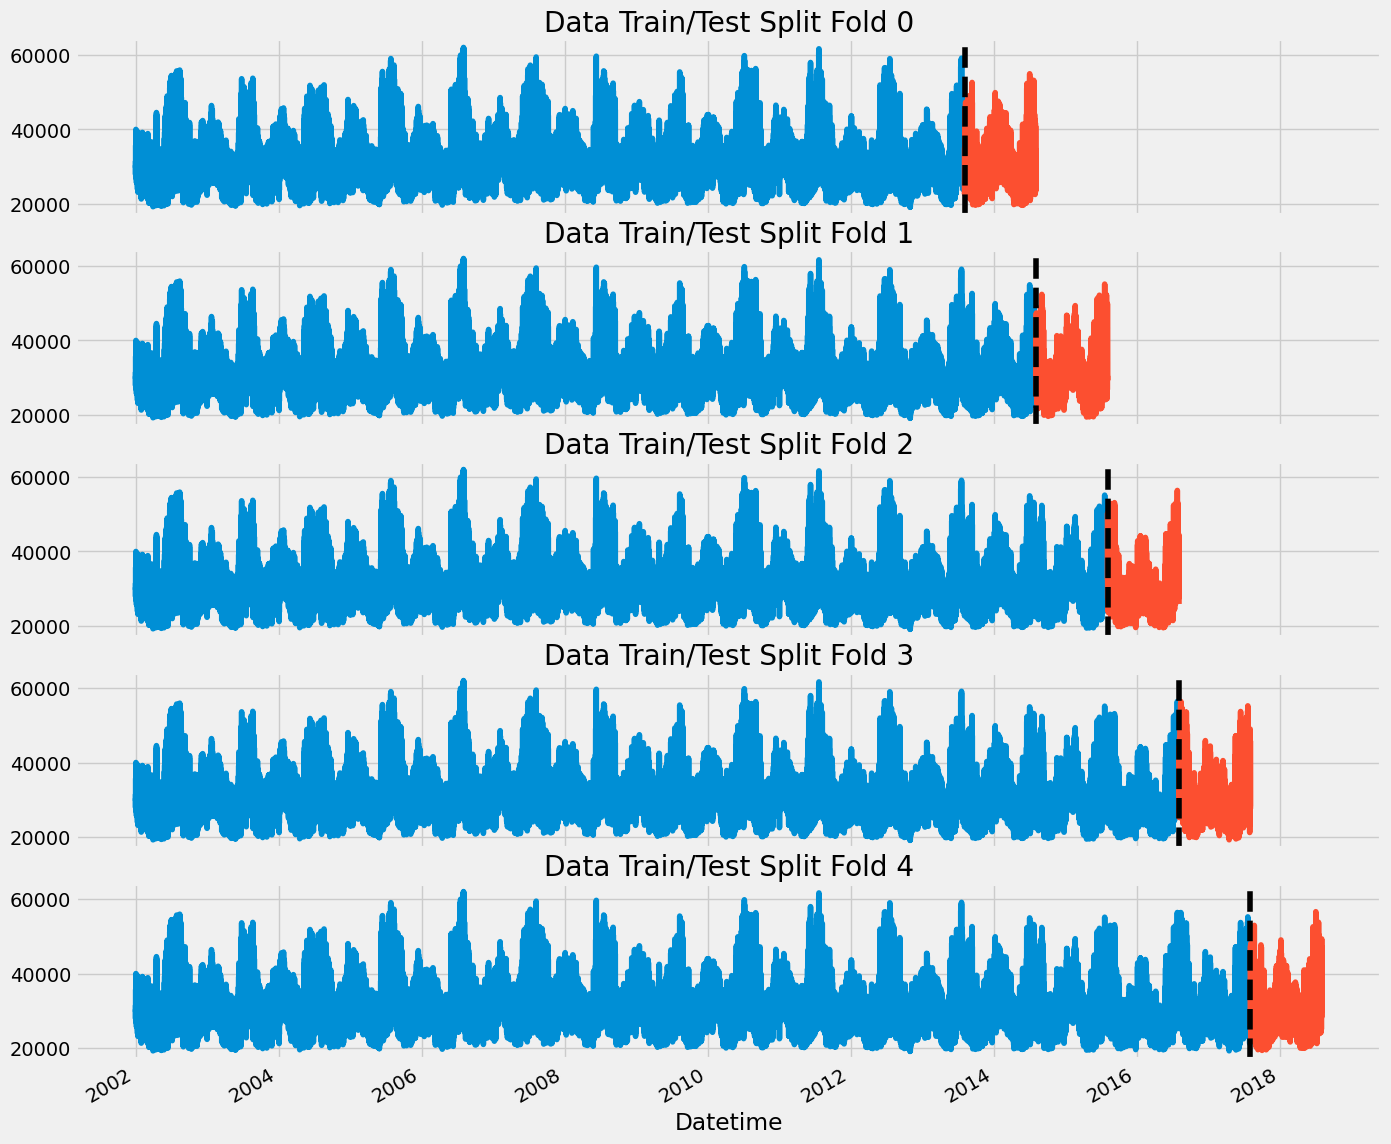

In [71]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

### 3. Lag Features

- What was the target (x) days in the past.

In [74]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [75]:
df = add_lags(df)

#### Train Using Cross Validation

In [76]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.29813	validation_1-rmse:31956.12901


C:\Users\saura\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:160: UserWarning: [21:37:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12532.43235	validation_1-rmse:11904.58782
[200]	validation_0-rmse:5744.95222	validation_1-rmse:5356.84300
[300]	validation_0-rmse:3871.90369	validation_1-rmse:3892.59716
[400]	validation_0-rmse:3435.02956	validation_1-rmse:3754.33238
[446]	validation_0-rmse:3364.90600	validation_1-rmse:3757.53894
[0]	validation_0-rmse:32671.76899	validation_1-rmse:32142.13679


C:\Users\saura\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:160: UserWarning: [21:38:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12513.53851	validation_1-rmse:12226.39459
[200]	validation_0-rmse:5755.01846	validation_1-rmse:5651.27874
[300]	validation_0-rmse:3906.82210	validation_1-rmse:3927.45255
[400]	validation_0-rmse:3478.17872	validation_1-rmse:3596.84442
[500]	validation_0-rmse:3352.66618	validation_1-rmse:3523.07822
[600]	validation_0-rmse:3296.70510	validation_1-rmse:3487.82916
[700]	validation_0-rmse:3257.73321	validation_1-rmse:3468.06020
[800]	validation_0-rmse:3222.25681	validation_1-rmse:3445.37604
[900]	validation_0-rmse:3192.52469	validation_1-rmse:3432.72311
[999]	validation_0-rmse:3165.63907	validation_1-rmse:3425.71868
[0]	validation_0-rmse:32630.97735	validation_1-rmse:31069.98153


C:\Users\saura\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:160: UserWarning: [21:39:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12498.81929	validation_1-rmse:11133.77575
[200]	validation_0-rmse:5749.69417	validation_1-rmse:4808.52984
[300]	validation_0-rmse:3914.33408	validation_1-rmse:3542.09733
[400]	validation_0-rmse:3492.92067	validation_1-rmse:3488.41143
[401]	validation_0-rmse:3491.30128	validation_1-rmse:3488.50653
[0]	validation_0-rmse:32528.18588	validation_1-rmse:31474.51358


C:\Users\saura\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:160: UserWarning: [21:40:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12462.18076	validation_1-rmse:12018.20453
[200]	validation_0-rmse:5737.83720	validation_1-rmse:5794.21490
[300]	validation_0-rmse:3914.73269	validation_1-rmse:4385.31167
[400]	validation_0-rmse:3497.45006	validation_1-rmse:4169.33613
[500]	validation_0-rmse:3382.37925	validation_1-rmse:4114.28118
[600]	validation_0-rmse:3323.85812	validation_1-rmse:4100.91700
[700]	validation_0-rmse:3282.58032	validation_1-rmse:4088.30188
[771]	validation_0-rmse:3258.52054	validation_1-rmse:4084.42225
[0]	validation_0-rmse:32461.76096	validation_1-rmse:31462.58329


C:\Users\saura\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:160: UserWarning: [21:41:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12445.41304	validation_1-rmse:11962.08478
[200]	validation_0-rmse:5751.81541	validation_1-rmse:5613.52924
[300]	validation_0-rmse:3951.49944	validation_1-rmse:4150.62570
[400]	validation_0-rmse:3540.50262	validation_1-rmse:4001.62992
[439]	validation_0-rmse:3482.16787	validation_1-rmse:4003.54837


In [77]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3746.8788
Fold scores:[3753.6176552727843, 3425.271376428151, 3473.313333085868, 4083.6723271785127, 3998.5195052083054]


### 4. Predicting the Future¶
- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [78]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32403.50092


C:\Users\saura\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:160: UserWarning: [21:45:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12426.68377
[200]	validation_0-rmse:5752.98750
[300]	validation_0-rmse:3972.52175
[400]	validation_0-rmse:3572.64777
[499]	validation_0-rmse:3458.28412


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [79]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [80]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [81]:
future_w_features = df_and_future.query('isFuture').copy()

#### Predict the future

In [82]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

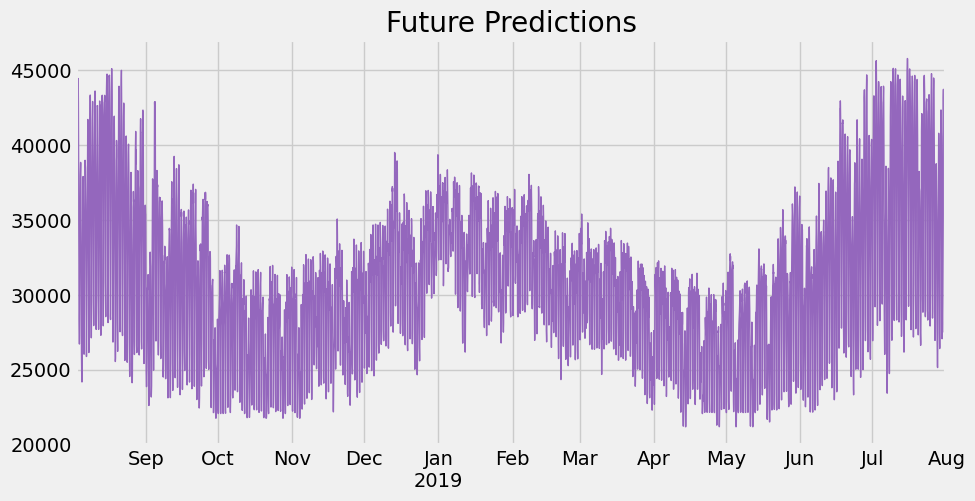

In [83]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

#### Saving Model For later

In [84]:
# Save model
reg.save_model('model.json')

<Axes: title={'center': 'Future Predictions'}>

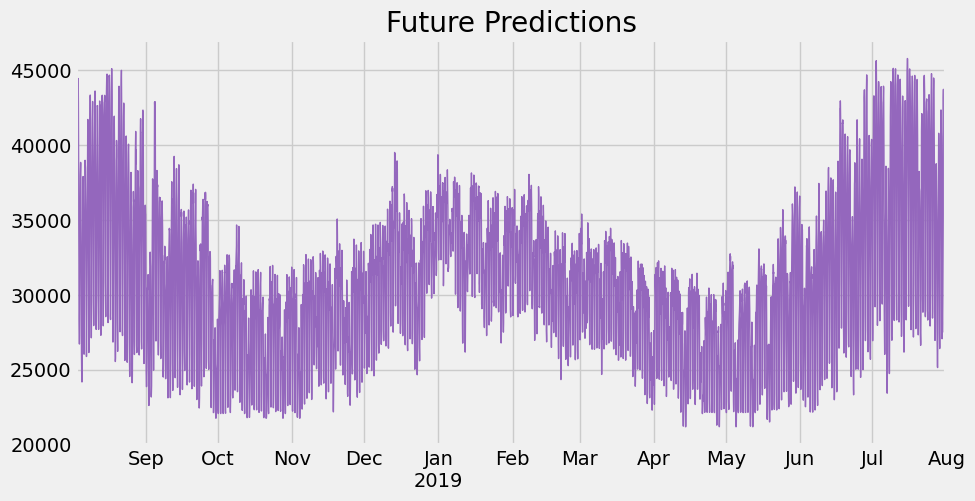

In [86]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')

### The End